In [103]:
from astroquery.vizier import Vizier
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord
from astropy import units as u
import math
import matplotlib.pyplot as plt
Vizier.ROW_LIMIT = -1
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import dbscan
from sklearn.cluster import DBSCAN
from sklearn.datasets import *
from astropy.table import Table
import numpy as np
import hdbscan
import pandas as pd
import seaborn as sns 
colour_pallette 

In [90]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': True,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

In [91]:
datafile = (Vizier.query_region(SkyCoord.from_name('NGC2355'),
                                 catalog='I/345/gaia2',
                                 radius=10*u.arcmin,
                                 column_filters={'e_Gmag': '<0.005'})[0]).to_pandas()

datafile

# 

,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,...,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
0,109.227513,0.0884,13.610620,0.0765,3166430592771952000,1.1987,0.1121,-3.977,0.185,-3.335,...,16.3182,0.0060,1.8783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109.232014,0.0213,13.615016,0.0191,3166430695851164416,0.0633,0.0251,0.391,0.042,-0.528,...,12.6586,0.0026,1.7316,NaN,NaN,4028.74,0.5217,0.2210,NaN,NaN
2,109.251320,0.2552,13.609517,0.2316,3166430657195248896,-0.1976,0.3424,-1.321,0.551,0.117,...,17.9753,0.0200,1.2297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,109.244308,0.2169,13.625936,0.1929,3166430725914746880,0.7522,0.2880,-1.396,0.434,-2.896,...,17.5953,0.0099,1.2298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,109.247346,0.2255,13.624913,0.1990,3166430725914745728,0.5575,0.3059,0.091,0.457,-2.148,...,17.9909,0.0393,1.1940,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,109.249919,0.3155,13.620435,0.2604,3166430725914740096,0.5639,0.3633,-2.179,0.611,0.718,...,18.2697,0.0232,1.9380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,109.256378,0.1186,13.619696,0.1116,3166430725914739328,0.0693,0.1361,-0.615,0.233,-0.694,...,17.1962,0.0076,0.8765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,109.252286,0.0249,13.626385,0.0238,3166430730210896768,0.9990,0.0276,0.580,0.049,-5.336,...,13.7232,0.0017,0.8612,NaN,NaN,5782.00,0.4010,0.1840,1.22,1.508
8,109.247298,0.0662,13.627254,0.0575,3166430730210897408,0.5130,0.0786,-3.866,0.128,-0.877,...,16.0217,0.0063,1.0542,NaN,NaN,5091.16,0.3800,0.2100,NaN,NaN
9,109.249720,0.1743,13.626336,0.1470,3166430725914747648,-0.1088,0.2088,-0.376,0.339,-1.691,...,17.7266,0.0192,1.0786,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# datafile['e_Gmag'] = abs(-2.5*datafile['FG']/math.log(10)/datafile['e_FG'])
# datafile['e_BPmag'] = abs(-2.5*datafile['FBP']/math.log(10)/datafile['e_FBP'])
# datafile['e_RPmag'] = abs(-2.5*datafile['FRP']/math.log(10)/datafile['e_FRP'])
datafile['BPRP'] = datafile['BPmag'] - datafile['RPmag']
data = datafile[(datafile['Plx'] > 0)]
print(len(data))

1222


In [93]:
df = data[["pmRA", "pmDE", "Plx"]]
df = df.to_numpy().astype("float32", copy = False)

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' 

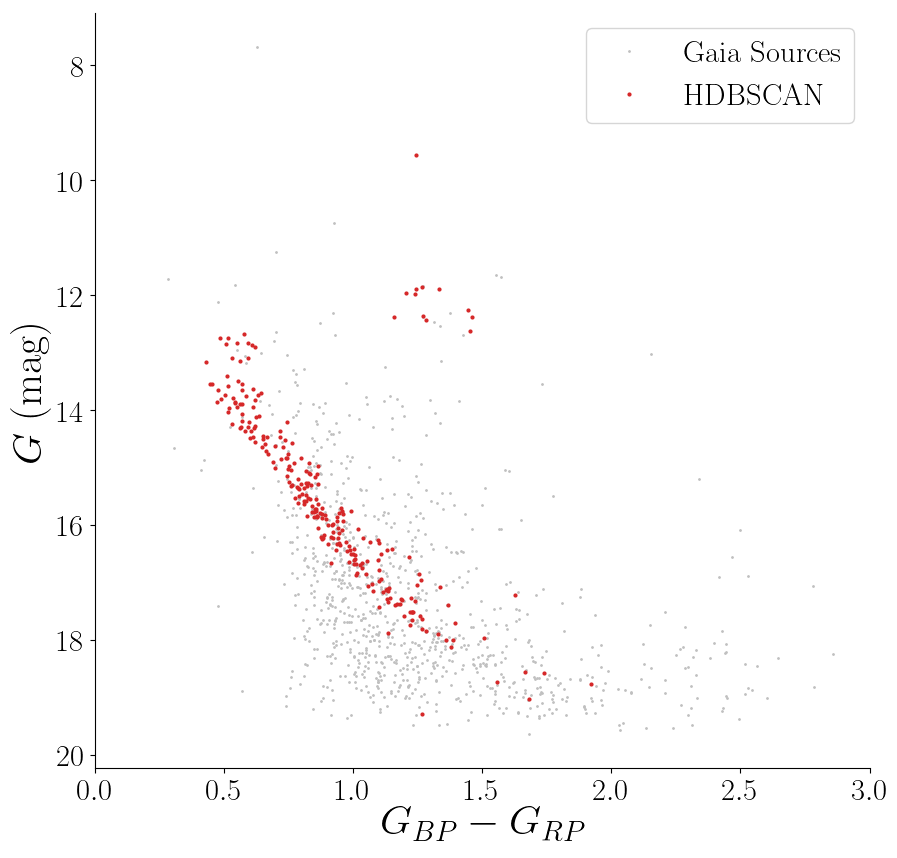

In [114]:
stscaler_df = StandardScaler().fit(df)
df_ = stscaler_df.transform(df)
clus_size = 2 * df_.shape[1]

clusterer = hdbscan.HDBSCAN(clus_size).fit(df_)

data['clus'] = clusterer.labels_
data['mem_prob'] = clusterer.probabilities_

result_hdbscan = data[data['clus'] >= 0].reset_index(drop=True)
c = result_hdbscan['clus'].value_counts()
n_max = c.index[np.argmax(c)]
result = data[data['clus'] == n_max]

plt.figure(figsize=(10, 10))
plt.plot(data['BPRP'], data['Gmag'], '.', mec='silver', mfc='darkgray', markersize=2., label="Gaia Sources")
plt.plot(result['BPRP'], result['Gmag'], 'o', color='tab:red', markersize=2., label=r"HDBSCAN")

plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G$ (mag)')

plt.xlim(0., 3.)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [115]:
result.head()

results_to_print = result[['RA_ICRS', 'DE_ICRS', 'e_RA_ICRS', 'e_DE_ICRS', 'mem_prob']]
results_to_print.to_csv('gaia_cluster_populations/NGC2355')
results_to_print.head()

,RA_ICRS,DE_ICRS,e_RA_ICRS,e_DE_ICRS,mem_prob
8,109.247298,13.627254,0.0662,0.0575,0.612145
16,109.209678,13.628453,0.0336,0.0324,0.927255
18,109.224372,13.640828,0.0632,0.0577,0.307066
20,109.226111,13.616056,0.0272,0.0275,0.840465
22,109.221129,13.638760,0.0952,0.0863,0.552154
